In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from datasets import *
import matplotlib.pyplot as plt
import cv2
from keras.datasets import mnist
import tensorflow as tf
import numpy as np
from random import randint
import keras
import keras.backend as K
from keras.models import Model, Sequential
from keras.layers.merge import Concatenate
from keras.layers import Input, Reshape, Dense, Conv2D, Dropout, \
    MaxPooling2D, Flatten, UpSampling2D, Multiply, Activation, AveragePooling2D, \
    Add, Subtract, Lambda
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, TensorBoard
from scipy.ndimage import gaussian_filter as blur
from keras.optimizers import Adam
from keras.utils import multi_gpu_model as mgpu
from keras.utils import np_utils
import os, sys

Using TensorFlow backend.


In [2]:
from models.gap import gap

model = gap(imsize=256)

 [!] Conv Spec:
 [!] 256 => 128: [64, 128]
 [!] 128 => 64: [256, 256, 256, 256]
 [!] 64 => 32: [256, 256, 256, 256]
 [!] 32 => 32: [512, 512, 512, 512]
 [!] 32 => 32: [512, 512, 512, 512]
 [!] 32 => 32: [512, 512, 512, 512]
 [!] 32 => 32: [1024, 2048]


In [3]:
print(model.count_params())
model.compile()

55.3 million


In [3]:
dset = Tissue()

 [*] tissue_sick: 733 unique cases


AssertionError: 

In [8]:
counter = 0
class Preview(keras.callbacks.Callback):
    def __init__(self, evalset):
        self.evalset = evalset
        _, _, _, refs = self.evalset
        
        print('Preview set:')
        for ii in range(7):
            print('  %s' % refs[ii].split('/')[-1])
        
    def on_batch_begin(self, batch, logs={}):
        global counter
        if counter % 100 == 0:
            model.save()
            imgs, masks, lbls, refs = self.evalset
            fmaps, _ = model.saliency(imgs)
            weights = model.core.layers[-2].get_weights()[0][:, 1] # weights for 1 output

            plt.figure(figsize=(14, 4))
            for ii in range(7): # preview 7 images
                A = np.zeros((32, 32))
                for jj in range(2048):
                    A += fmaps[ii, :, :, jj] * weights[jj]
            
                plt.subplot(3, 7, ii+1)
                plt.axis('off')
                plt.imshow(imgs[ii, :, :, 0])
                plt.subplot(3, 7, 7+ii+1)
                plt.axis('off')
#                 plt.gca().set_title(np.min(A), np.max(A))
                plt.imshow(masks[ii, :, :, 0], vmin=0, vmax=1)
                plt.subplot(3, 7, 14+ii+1)
                plt.axis('off')
#                 plt.gca().set_title('%.2f~%.2f' % (np.min(A), np.max(A)))
                A -= np.min(A)
                A /= np.max(A)
                plt.imshow(A, vmin=0, vmax=1)
            plt.show()
            plt.close()
        counter += 1
        return

In [9]:
bsize=16

datagen = dset.gen(bsize=bsize,labels=['lbls'])
previewset = next(dset.gen(bsize=bsize, labels=['lbls', 'masks', 'refs'], mode='test', sickonly=True))
evalgen = dset.gen(bsize=bsize, labels=['lbls'], mode='test')

Preview set:
  00600_LEFT_MLO_1_49.npy
  00600_LEFT_MLO_1_49.npy
  00098_RIGHT_MLO_0_15.npy
  00105_LEFT_CC_0_23.npy
  00198_LEFT_CC_0_11.npy
  01099_LEFT_CC_3_39.npy
  01270_RIGHT_MLO_0_9.npy
Epoch 1/8


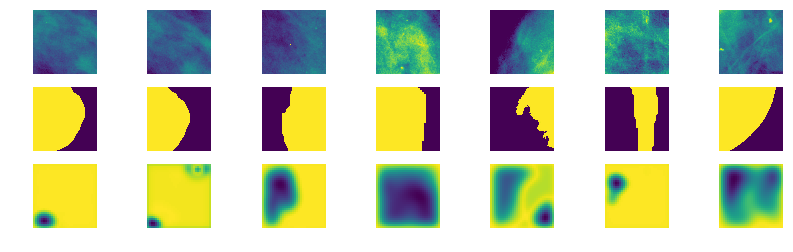

   1/2633 [..............................] - ETA: 1:59:26 - loss: 0.0400 - acc: 1.0000

/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:97: UserWarning: Method on_batch_begin() is slow compared to the batch update (0.905324). Check your callbacks.
  % delta_t_median)


  11/2633 [..............................] - ETA: 38:39 - loss: 0.1322 - acc: 0.9375

KeyboardInterrupt: 

In [10]:


model.model.fit_generator(
    datagen,
    epochs=8,
    verbose=1,
    steps_per_epoch=dset.train_size // bsize // 2, # do half at a time
    
    validation_data=evalgen,
    validation_steps=dset.test_size // bsize // 10, # just do 10th of val data
    
    callbacks=[Preview(previewset)]
)
